In [77]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

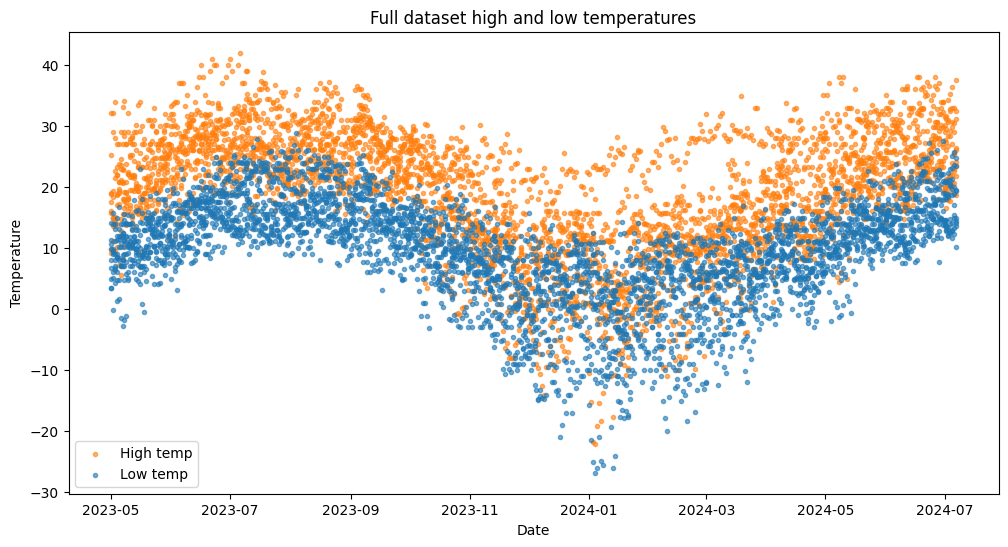

In [78]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(12, 6))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [79]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [80]:
data.duplicated().sum()

0

In [81]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

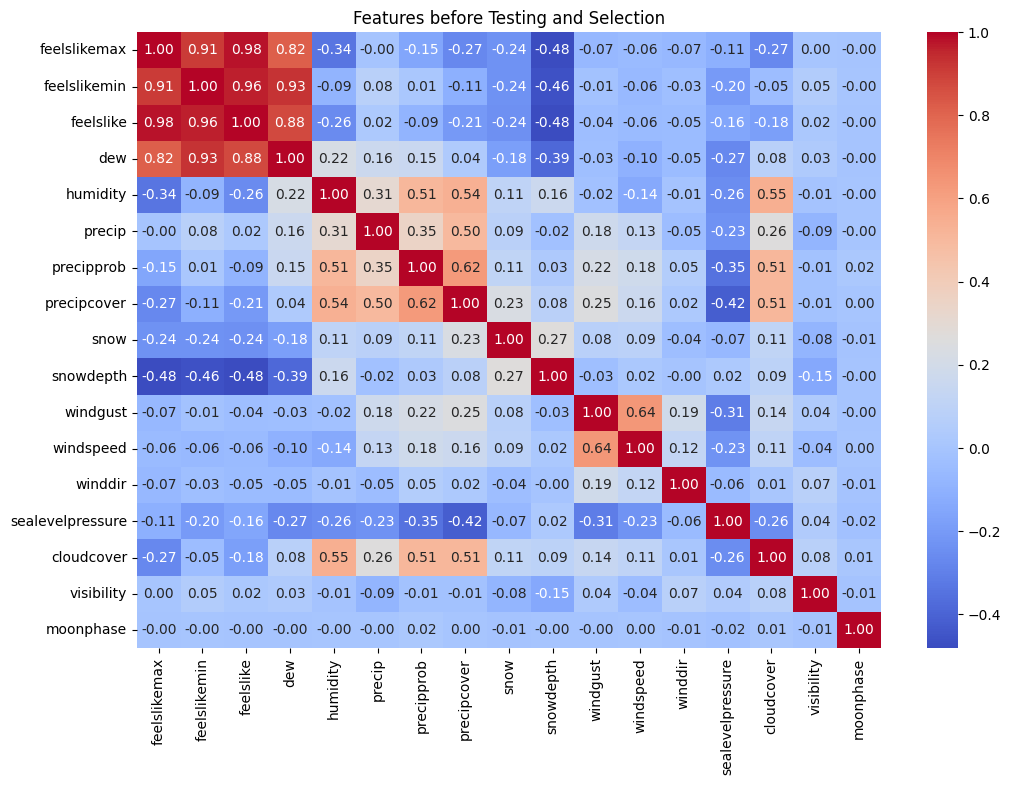

In [82]:
all_features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

y_max = df['tempmax']
y_min = df['tempmin']

df = df.select_dtypes(include=['number'])
correlation_matrix = all_features.corr()
plt.figure(figsize=(12, 8))
plt.title("Features before Testing and Selection")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

## Feature Engineering and Selection

In [83]:
# Define the DataFrame with combined highly correlated features for tempmax and tempmin
df['feelslike_max_combined'] = df[['feelslikemax', 'feelslike']].mean(axis=1)
df['feelslike_min_combined'] = df[['feelslikemin', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features tempmax
features_combined_max = df[['feelslike_max_combined', 'dew_humidity', 'windspeed']]

# Recalculate the features DataFrame without the original features tempmin
features_combined_min = df[['feelslike_min_combined', 'dew_humidity', 'windspeed']]

In [84]:
""" Addressing Multicollinearity with Variance Inflation Factor"""
# Calculate VIF for each Feature tempmax
vif_data = pd.DataFrame()
vif_data["tempmax feature"] = features_combined_max.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Display features with high VIF tempmax
print( vif_data.sort_values(by="VIF", ascending=False))

# Calculate VIF for each Feature tempmin
vif_data = pd.DataFrame()
vif_data["tempmin feature"] = features_combined_min.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined_min.values, i) for i in range(features_combined_min.shape[1])]

# Display Features with High VIF tempmin
print( vif_data.sort_values(by="VIF", ascending=False))

          tempmax feature       VIF
1            dew_humidity  6.635189
2               windspeed  5.230312
0  feelslike_max_combined  3.214948
          tempmin feature       VIF
1            dew_humidity  6.478364
2               windspeed  5.145125
0  feelslike_min_combined  2.323773


## Train-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [85]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

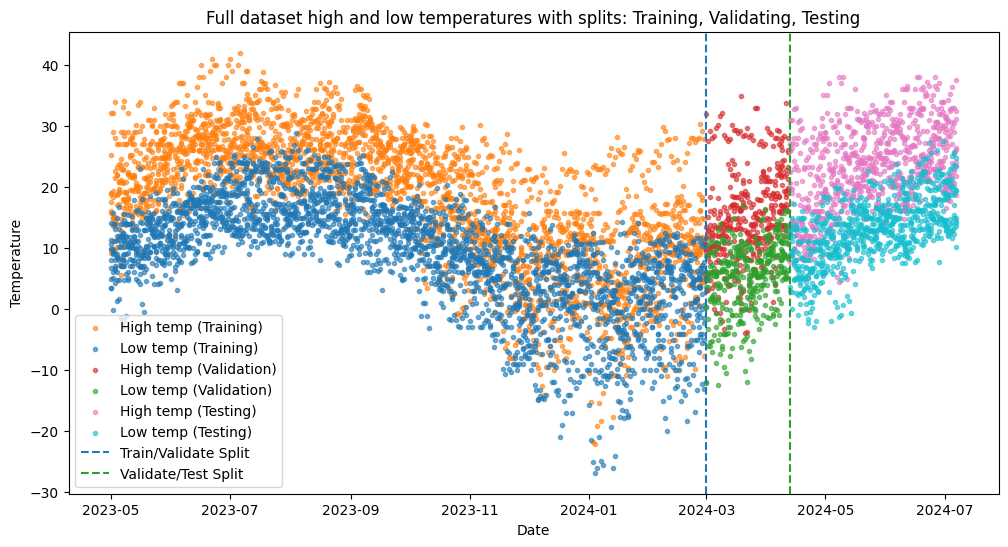

In [86]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [87]:
# Define feature set with combined features based on
X_max = ['feelslike_max_combined', 'dew_humidity', 'windspeed']
X_min = ['feelslike_min_combined', 'dew_humidity', 'windspeed']

# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets tempmax
X_train_max = train[X_max]
X_validate_max = validate[X_max]
X_test_max = test[X_max]

# Define feature sets tempmin
X_train_min = train[X_min]
X_validate_min = validate[X_min]
X_test_min = test[X_min]

##  Model Cross Validation/Picking a Model

In [88]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}

# Perform cross-validation and evaluate each model for tempmax
print("Cross-Validation Scores for tempmax:")
for name, model in models.items():
    cv_scores_max = cross_val_score(model, X_train_max, y_train_max, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {cv_scores_max.mean()}")

# Perform cross-validation and evaluate each model for tempmin
print("\nCross-Validation Scores for tempmin:")
for name, model in models.items():
    cv_scores_min = cross_val_score(model, X_train_min, y_train_min, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {cv_scores_min.mean()}")


Cross-Validation Scores for tempmax:
Linear Regression - Cross-Validated R²: 0.981140116808495
Ridge Regression - Cross-Validated R²: 0.9811401235429568
Lasso Regression - Cross-Validated R²: 0.9810492698306159
Random Forest - Cross-Validated R²: 0.9858455459051442
Gradient Boosting - Cross-Validated R²: 0.9868654439162665
Support Vector Regression - Cross-Validated R²: 0.9695173310619751

Cross-Validation Scores for tempmin:
Linear Regression - Cross-Validated R²: 0.9613062148126016
Ridge Regression - Cross-Validated R²: 0.9613064626451852
Lasso Regression - Cross-Validated R²: 0.9629850167667453
Random Forest - Cross-Validated R²: 0.9661141598938816
Gradient Boosting - Cross-Validated R²: 0.9694364772349247
Support Vector Regression - Cross-Validated R²: 0.9505732717197176


## Model Training and Evaluation
### Gradient Boosting based on Cross Validation Results

In [103]:
# Initialize and fit the Gradient Boosting model for tempmax with the best parameters
gb_model_max = GradientBoostingRegressor(
    learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.9, random_state=42
)
gb_model_max.fit(X_train_max, y_train_max)

# Initialize and fit the Gradient Boosting model for tempmin with the best parameters
gb_model_min = GradientBoostingRegressor(
    learning_rate=0.05, max_depth=3, n_estimators=300, subsample=0.9, random_state=42
)
gb_model_min.fit(X_train_min, y_train_min)

# Make predictions for the training set
y_pred_train_max_gb = gb_model_max.predict(X_train_max)
y_pred_train_min_gb = gb_model_min.predict(X_train_min)

# Evaluate the model performance for tempmax
r2_train_max_gb = r2_score(y_train_max, y_pred_train_max_gb)
mse_train_max_gb = mean_squared_error(y_train_max, y_pred_train_max_gb)
mae_train_max_gb = mean_absolute_error(y_train_max, y_pred_train_max_gb)

print(f"Gradient Boosting Train R² for TempMax: {r2_train_max_gb}")
print(f"Gradient Boosting Train MSE for TempMax: {mse_train_max_gb}")
print(f"Gradient Boosting Train MAE for TempMax: {mae_train_max_gb}")

# Evaluate the model performance for tempmin
r2_train_min_gb = r2_score(y_train_min, y_pred_train_min_gb)
mse_train_min_gb = mean_squared_error(y_train_min, y_pred_train_min_gb)
mae_train_min_gb = mean_absolute_error(y_train_min, y_pred_train_min_gb)

print(f"Gradient Boosting Train R² for TempMin: {r2_train_min_gb}")
print(f"Gradient Boosting Train MSE for TempMin: {mse_train_min_gb}")
print(f"Gradient Boosting Train MAE for TempMin: {mae_train_min_gb}")

Gradient Boosting Train R² for TempMax: 0.9943058903051066
Gradient Boosting Train MSE for TempMax: 0.6221629683899114
Gradient Boosting Train MAE for TempMax: 0.6161695841451957
Gradient Boosting Train R² for TempMin: 0.9884045200805209
Gradient Boosting Train MSE for TempMin: 0.9097014344833497
Gradient Boosting Train MAE for TempMin: 0.7209065980280001


In [99]:
# Make predictions for the validation set
y_pred_validate_max_gb = gb_model_max.predict(X_validate_max)
y_pred_validate_min_gb = gb_model_min.predict(X_validate_min)

# Make predictions for the test set
y_pred_test_max_gb = gb_model_max.predict(X_test_max)
y_pred_test_min_gb = gb_model_min.predict(X_test_min)

# Evaluate the model performance on the validation set for tempmax
r2_validate_max_gb = r2_score(y_validate_max, y_pred_validate_max_gb)
mse_validate_max_gb = mean_squared_error(y_validate_max, y_pred_validate_max_gb)
mae_validate_max_gb = mean_absolute_error(y_validate_max, y_pred_validate_max_gb)

print(f"Gradient Boosting Validation R² for TempMax: {r2_validate_max_gb}")
print(f"Gradient Boosting Validation MSE for TempMax: {mse_validate_max_gb}")
print(f"Gradient Boosting Validation MAE for TempMax: {mae_validate_max_gb}")

# Evaluate the model performance on the validation set for tempmin
r2_validate_min_gb = r2_score(y_validate_min, y_pred_validate_min_gb)
mse_validate_min_gb = mean_squared_error(y_validate_min, y_pred_validate_min_gb)
mae_validate_min_gb = mean_absolute_error(y_validate_min, y_pred_validate_min_gb)

print(f"Gradient Boosting Validation R² for TempMin: {r2_validate_min_gb}")
print(f"Gradient Boosting Validation MSE for TempMin: {mse_validate_min_gb}")
print(f"Gradient Boosting Validation MAE for TempMin: {mae_validate_min_gb}")

# Evaluate the model performance on the test set for tempmax
r2_test_max_gb = r2_score(y_test_max, y_pred_test_max_gb)
mse_test_max_gb = mean_squared_error(y_test_max, y_pred_test_max_gb)
mae_test_max_gb = mean_absolute_error(y_test_max, y_pred_test_max_gb)

print(f"Gradient Boosting Test R² for TempMax: {r2_test_max_gb}")
print(f"Gradient Boosting Test MSE for TempMax: {mse_test_max_gb}")
print(f"Gradient Boosting Test MAE for TempMax: {mae_test_max_gb}")

# Evaluate the model performance on the test set for tempmin
r2_test_min_gb = r2_score(y_test_min, y_pred_test_min_gb)
mse_test_min_gb = mean_squared_error(y_test_min, y_pred_test_min_gb)
mae_test_min_gb = mean_absolute_error(y_test_min, y_pred_test_min_gb)

print(f"Gradient Boosting Test R² for TempMin: {r2_test_min_gb}")
print(f"Gradient Boosting Test MSE for TempMin: {mse_test_min_gb}")
print(f"Gradient Boosting Test MAE for TempMin: {mae_test_min_gb}")


Gradient Boosting Validation R² for TempMax: 0.9835953711020092
Gradient Boosting Validation MSE for TempMax: 0.9141238869925858
Gradient Boosting Validation MAE for TempMax: 0.7378494296300563
Gradient Boosting Validation R² for TempMin: 0.9294664272482821
Gradient Boosting Validation MSE for TempMin: 2.2191033520621692
Gradient Boosting Validation MAE for TempMin: 1.0972803999587168
Gradient Boosting Test R² for TempMax: 0.9823145990877795
Gradient Boosting Test MSE for TempMax: 0.8008517425141014
Gradient Boosting Test MAE for TempMax: 0.6989726708388403
Gradient Boosting Test R² for TempMin: 0.9559824676171392
Gradient Boosting Test MSE for TempMin: 1.2027152469544118
Gradient Boosting Test MAE for TempMin: 0.8704011119808434


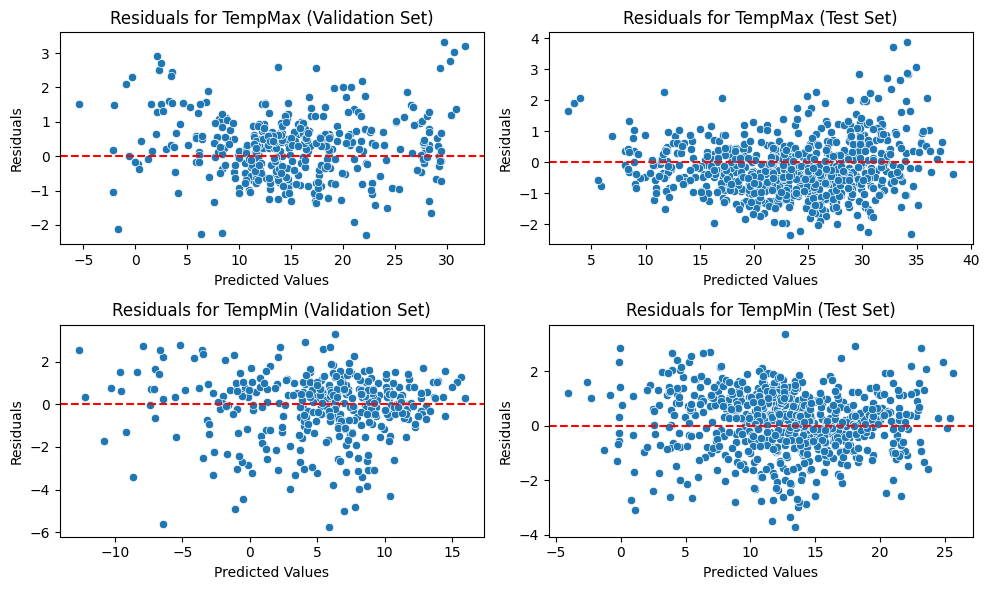

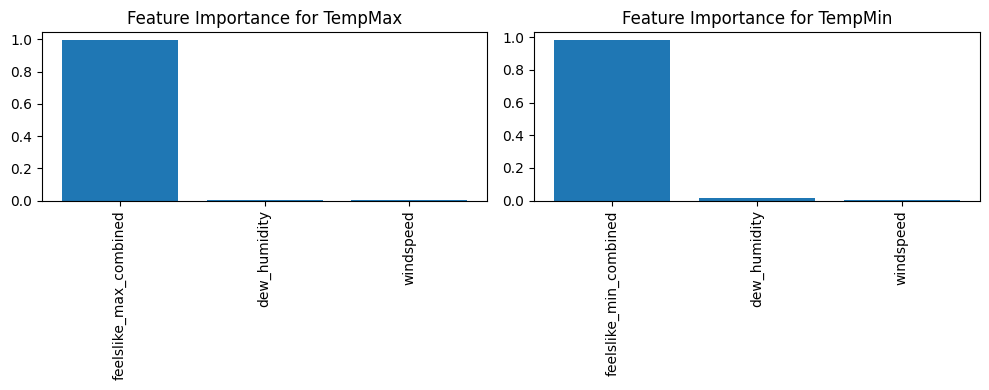

In [100]:
# Residual Analysis
def plot_residuals(ax, y_true, y_pred, title):
    residuals = y_true - y_pred
    sns.scatterplot(x=y_pred, y=residuals, ax=ax)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Residuals')
    ax.set_title(title)

# Feature Importance
def plot_feature_importance(ax, model, X_train, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    ax.bar(range(X_train.shape[1]), importances[indices], align='center')
    ax.set_xticks(range(X_train.shape[1]))
    ax.set_xticklabels(X_train.columns[indices], rotation=90)
    ax.set_title(title)

# Create subplots for residuals
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Residuals for TempMax (Validation Set)
plot_residuals(axes[0, 0], y_validate_max, y_pred_validate_max_gb, 'Residuals for TempMax (Validation Set)')

# Residuals for TempMax (Test Set)
plot_residuals(axes[0, 1], y_test_max, y_pred_test_max_gb, 'Residuals for TempMax (Test Set)')

# Residuals for TempMin (Validation Set)
plot_residuals(axes[1, 0], y_validate_min, y_pred_validate_min_gb, 'Residuals for TempMin (Validation Set)')

# Residuals for TempMin (Test Set)
plot_residuals(axes[1, 1], y_test_min, y_pred_test_min_gb, 'Residuals for TempMin (Test Set)')

# Adjust layout
plt.tight_layout()
plt.show()

# Create subplots for feature importance
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Feature Importance for TempMax
plot_feature_importance(axes[0], gb_model_max, X_train_max, 'Feature Importance for TempMax')

# Feature Importance for TempMin
plot_feature_importance(axes[1], gb_model_min, X_train_min, 'Feature Importance for TempMin')

# Adjust layout
plt.tight_layout()
plt.show()

### RFE  adn Cross Validation Results Before Feature Engineering and Selection:
- Selected features for TempMax: Index(['feelslikemax', 'feelslike', 'dew', 'humidity', 'windspeed'], dtype='object')
- Selected features for TempMin: Index(['feelslikemin', 'feelslike', 'dew', 'humidity', 'windspeed'], dtype='object')
- Cross-Validated R² for TempMax with selected features: 0.9939062811370143
- Cross-Validated R² for TempMin with selected features: 0.9903312662801647a

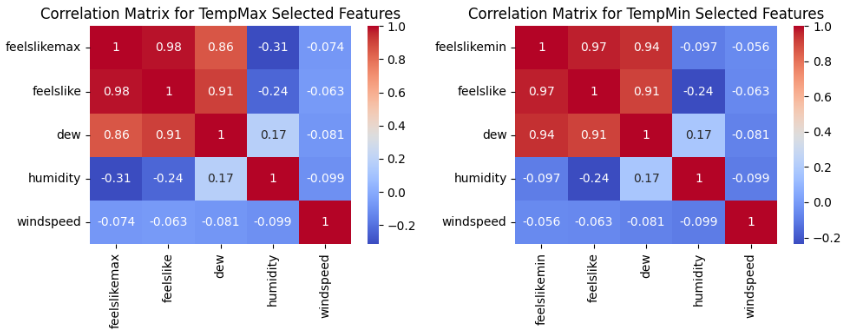

In [92]:
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

# RFE for TempMax
rfe_max = RFE(estimator=gb_model_max, n_features_to_select=5, step=1)
rfe_max.fit(X_train_max, y_train_max)
print("Selected features for TempMax:", X_train_max.columns[rfe_max.support_])

# RFE for TempMin
rfe_min = RFE(estimator=gb_model_min, n_features_to_select=5, step=1)
rfe_min.fit(X_train_min, y_train_min)
print("Selected features for TempMin:", X_train_min.columns[rfe_min.support_])

# Evaluate model performance with selected features
selected_features_max = X_train_max.columns[rfe_max.support_]
selected_features_min = X_train_min.columns[rfe_min.support_]

X_train_selected_max = X_train_max[selected_features_max]
X_test_selected_max = X_test_max[selected_features_max]
X_train_selected_min = X_train_min[selected_features_min]
X_test_selected_min = X_test_min[selected_features_min]

# Cross-validation for TempMax
cv_scores_max = cross_val_score(gb_model_max, X_train_selected_max, y_train_max, cv=5, scoring='r2')
print("Cross-Validated R² for TempMax with selected features:", cv_scores_max.mean())

# Cross-validation for TempMin
cv_scores_min = cross_val_score(gb_model_min, X_train_selected_min, y_train_min, cv=5, scoring='r2')
print("Cross-Validated R² for TempMin with selected features:", cv_scores_min.mean())


/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=5 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected features for TempMax: Index(['feelslike_max_combined', 'dew_humidity', 'windspeed'], dtype='object')


/home/ahzof/hw_ds/.venv/lib/python3.10/site-packages/sklearn/feature_selection/_rfe.py:291: UserWarning: Found n_features_to_select=5 > n_features=3. There will be no feature selection and all features will be kept.
  warnings.warn(


Selected features for TempMin: Index(['feelslike_min_combined', 'dew_humidity', 'windspeed'], dtype='object')
Cross-Validated R² for TempMax with selected features: 0.9868654439162665
Cross-Validated R² for TempMin with selected features: 0.9694364772349247


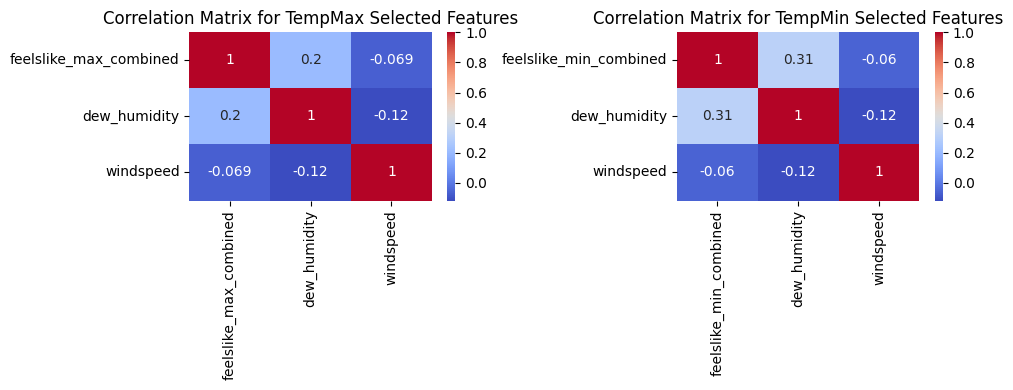

In [93]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Correlation matrix for TempMax selected features
corr_matrix_max = X_train_max[selected_features_max].corr()
sns.heatmap(corr_matrix_max, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title("Correlation Matrix for TempMax Selected Features")

# Correlation matrix for TempMin selected features
corr_matrix_min = X_train_min[selected_features_min].corr()
sns.heatmap(corr_matrix_min, annot=True, cmap='coolwarm', ax=axes[1])
axes[1].set_title("Correlation Matrix for TempMin Selected Features")

# Adjust layout
plt.tight_layout()
plt.show()

- Best parameters for TempMax: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
- Best R² for TempMax: 0.9871109251522177
- Best parameters for TempMin: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.9}
- Best R² for TempMin: 0.970128418377233


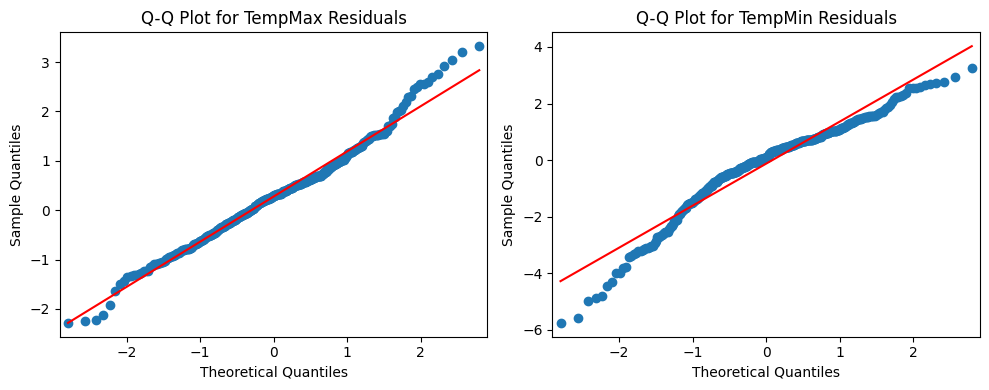

In [101]:
# Q-Q Plot for Residuals
def plot_qq(ax, residuals, title):
    qqplot(residuals, line='s', ax=ax)
    ax.set_title(title)

# Create subplots for Q-Q plots
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Q-Q Plot for TempMax residuals
plot_qq(axes[0], y_validate_max - y_pred_validate_max_gb, 'Q-Q Plot for TempMax Residuals')

# Q-Q Plot for TempMin residuals
plot_qq(axes[1], y_validate_min - y_pred_validate_min_gb, 'Q-Q Plot for TempMin Residuals')

# Adjust layout
plt.tight_layout()
plt.show()


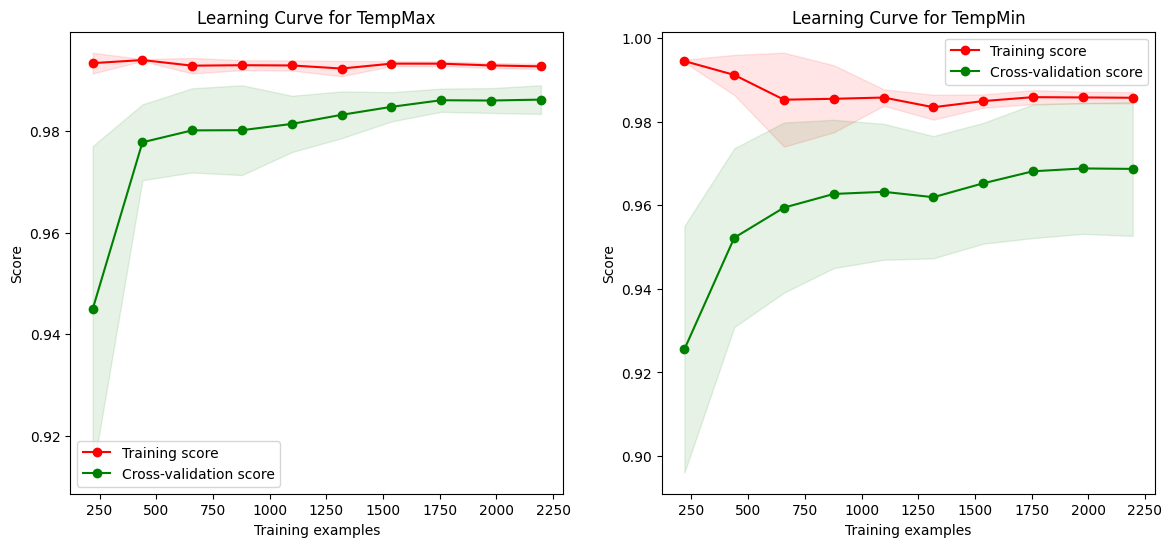

In [102]:
# Function to plot learning curve
def plot_learning_curve(estimator, X, y, ax, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Plot learning curves for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_learning_curve(gb_model_max, X_train_max, y_train_max, axes[0], title="Learning Curve for TempMax")
plot_learning_curve(gb_model_min, X_train_min, y_train_min, axes[1], title="Learning Curve for TempMin")

plt.show()

Gradient Boosting Train R² for TempMax: 0.9713582678373207
Gradient Boosting Train MSE for TempMax: 3.1295191095708095
Gradient Boosting Train MAE for TempMax: 1.1981203948811905
Gradient Boosting Train R² for TempMin: 0.9566756870173276
Gradient Boosting Train MSE for TempMin: 3.398926990691831
Gradient Boosting Train MAE for TempMin: 1.2992294348594329


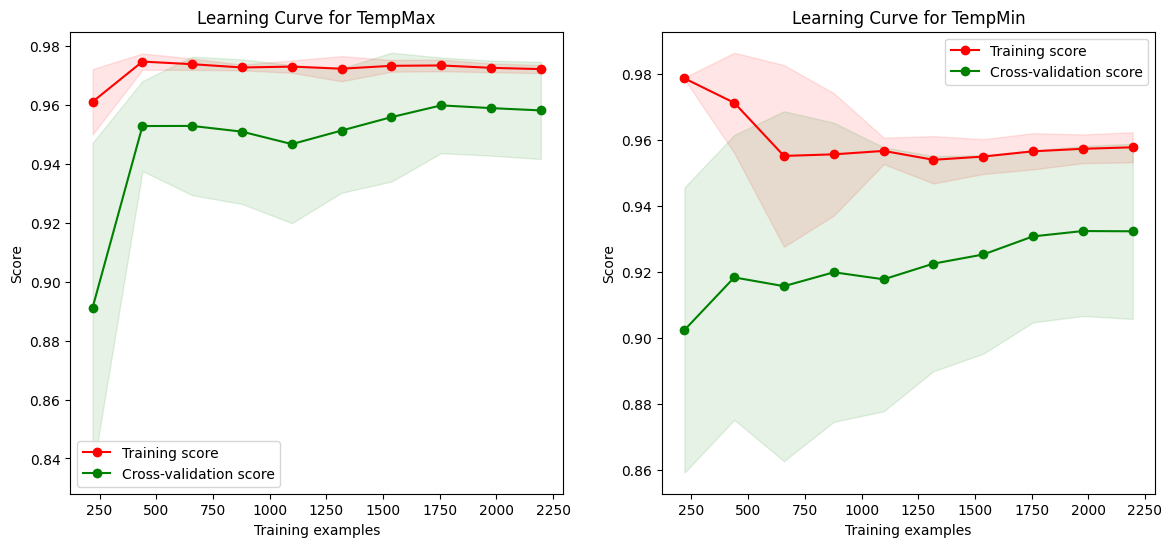

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Initialize and fit the Gradient Boosting model for tempmax with modified parameters
gb_model_max = GradientBoostingRegressor(
    learning_rate=0.05, max_depth=1, n_estimators=100, subsample=0.9, min_samples_split=5, random_state=42
)
gb_model_max.fit(X_train_max, y_train_max)

# Initialize and fit the Gradient Boosting model for tempmin with modified parameters
gb_model_min = GradientBoostingRegressor(
    learning_rate=0.05, max_depth=1, n_estimators=100, subsample=0.9, min_samples_split=5, random_state=42
)
gb_model_min.fit(X_train_min, y_train_min)

# Make predictions for the training set
y_pred_train_max_gb = gb_model_max.predict(X_train_max)
y_pred_train_min_gb = gb_model_min.predict(X_train_min)

# Evaluate the model performance for tempmax
r2_train_max_gb = r2_score(y_train_max, y_pred_train_max_gb)
mse_train_max_gb = mean_squared_error(y_train_max, y_pred_train_max_gb)
mae_train_max_gb = mean_absolute_error(y_train_max, y_pred_train_max_gb)

print(f"Gradient Boosting Train R² for TempMax: {r2_train_max_gb}")
print(f"Gradient Boosting Train MSE for TempMax: {mse_train_max_gb}")
print(f"Gradient Boosting Train MAE for TempMax: {mae_train_max_gb}")

# Evaluate the model performance for tempmin
r2_train_min_gb = r2_score(y_train_min, y_pred_train_min_gb)
mse_train_min_gb = mean_squared_error(y_train_min, y_pred_train_min_gb)
mae_train_min_gb = mean_absolute_error(y_train_min, y_pred_train_min_gb)

print(f"Gradient Boosting Train R² for TempMin: {r2_train_min_gb}")
print(f"Gradient Boosting Train MSE for TempMin: {mse_train_min_gb}")
print(f"Gradient Boosting Train MAE for TempMin: {mae_train_min_gb}")

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, ax, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Plot learning curves for both models
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_learning_curve(gb_model_max, X_train_max, y_train_max, axes[0], title="Learning Curve for TempMax")
plot_learning_curve(gb_model_min, X_train_min, y_train_min, axes[1], title="Learning Curve for TempMin")

plt.show()


Ridge Regression Train R² for TempMax: 0.984634770718411
Ridge Regression Train MSE for TempMax: 1.678871179527561
Ridge Regression Train MAE for TempMax: 1.0000608427282607
Ridge Regression Train R² for TempMin: 0.9751061856202267
Ridge Regression Train MSE for TempMin: 1.952997099585284
Ridge Regression Train MAE for TempMin: 1.0470637632602406


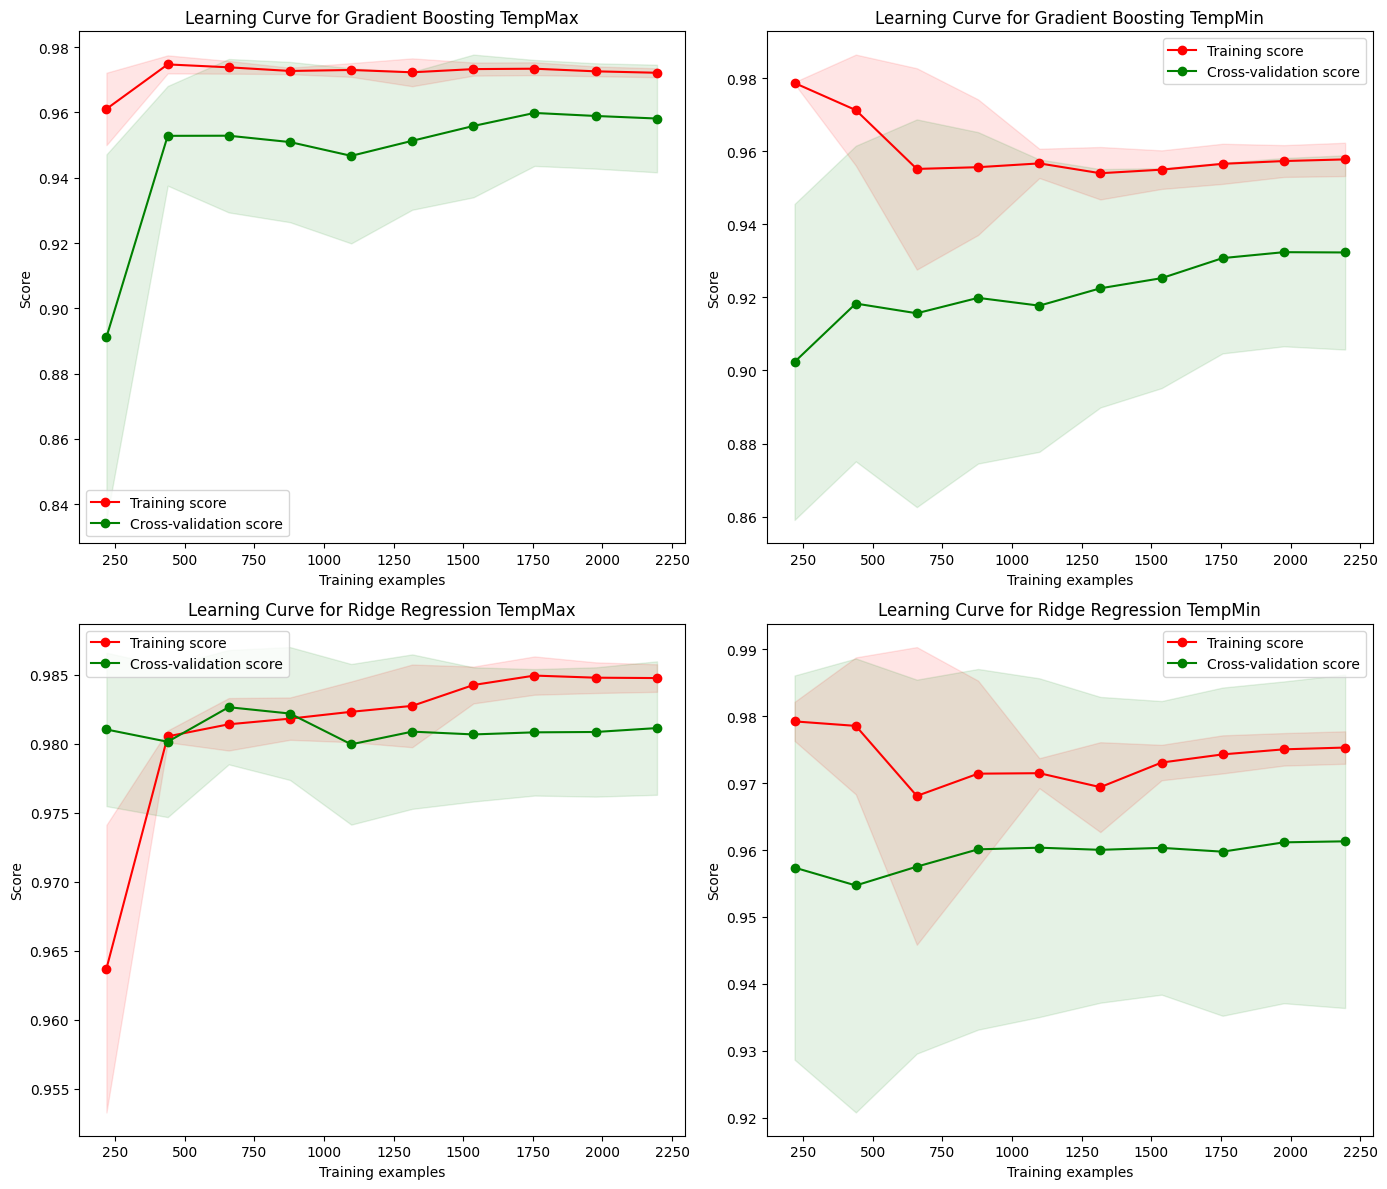

In [107]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import learning_curve

# Initialize and fit the Ridge Regression model for tempmax
ridge_model_max = Ridge(alpha=1.0)
ridge_model_max.fit(X_train_max, y_train_max)

# Initialize and fit the Ridge Regression model for tempmin
ridge_model_min = Ridge(alpha=1.0)
ridge_model_min.fit(X_train_min, y_train_min)

# Make predictions for the training set
y_pred_train_max_ridge = ridge_model_max.predict(X_train_max)
y_pred_train_min_ridge = ridge_model_min.predict(X_train_min)

# Evaluate the model performance for tempmax
r2_train_max_ridge = r2_score(y_train_max, y_pred_train_max_ridge)
mse_train_max_ridge = mean_squared_error(y_train_max, y_pred_train_max_ridge)
mae_train_max_ridge = mean_absolute_error(y_train_max, y_pred_train_max_ridge)

print(f"Ridge Regression Train R² for TempMax: {r2_train_max_ridge}")
print(f"Ridge Regression Train MSE for TempMax: {mse_train_max_ridge}")
print(f"Ridge Regression Train MAE for TempMax: {mae_train_max_ridge}")

# Evaluate the model performance for tempmin
r2_train_min_ridge = r2_score(y_train_min, y_pred_train_min_ridge)
mse_train_min_ridge = mean_squared_error(y_train_min, y_pred_train_min_ridge)
mae_train_min_ridge = mean_absolute_error(y_train_min, y_pred_train_min_ridge)

print(f"Ridge Regression Train R² for TempMin: {r2_train_min_ridge}")
print(f"Ridge Regression Train MSE for TempMin: {mse_train_min_ridge}")
print(f"Ridge Regression Train MAE for TempMin: {mae_train_min_ridge}")

# Function to plot learning curve
def plot_learning_curve(estimator, X, y, ax, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='r2', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend(loc="best")

# Plot learning curves for both models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

plot_learning_curve(gb_model_max, X_train_max, y_train_max, axes[0, 0], title="Learning Curve for Gradient Boosting TempMax")
plot_learning_curve(gb_model_min, X_train_min, y_train_min, axes[0, 1], title="Learning Curve for Gradient Boosting TempMin")
plot_learning_curve(ridge_model_max, X_train_max, y_train_max, axes[1, 0], title="Learning Curve for Ridge Regression TempMax")
plot_learning_curve(ridge_model_min, X_train_min, y_train_min, axes[1, 1], title="Learning Curve for Ridge Regression TempMin")

plt.tight_layout()
plt.show()
